<style>
.custom-font {
    font-family: 'Times New Roman', Times, serif;
    font-size: 48px;
    background-color: lightblue;
    color: black
}
</style>

<p class="custom-font">
DataLoader General



</p>


In [1]:
import torch
import torch_geometric
import h5py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from torch_geometric.utils import to_undirected

In [2]:
import sys
sys.path.insert(0, '..')
from datasets import PneumaTrajectoryDataset

In [3]:
data = PneumaTrajectoryDataset('../data/pneuma_merged.h5', n_samples=10, min_trajectory_length=5, max_trajectory_length=8, edge_format='srctar')

In [4]:
# check the data format
print(type(data))

print(type(data[0]))
print(data[0].shape)
print(data[0])

print(data[0][2])

<class 'datasets.PneumaTrajectoryDataset'>
<class 'numpy.ndarray'>
(5, 2)
[[277 266]
 [266 267]
 [267 279]
 [279 281]
 [281 299]]
[267 279]


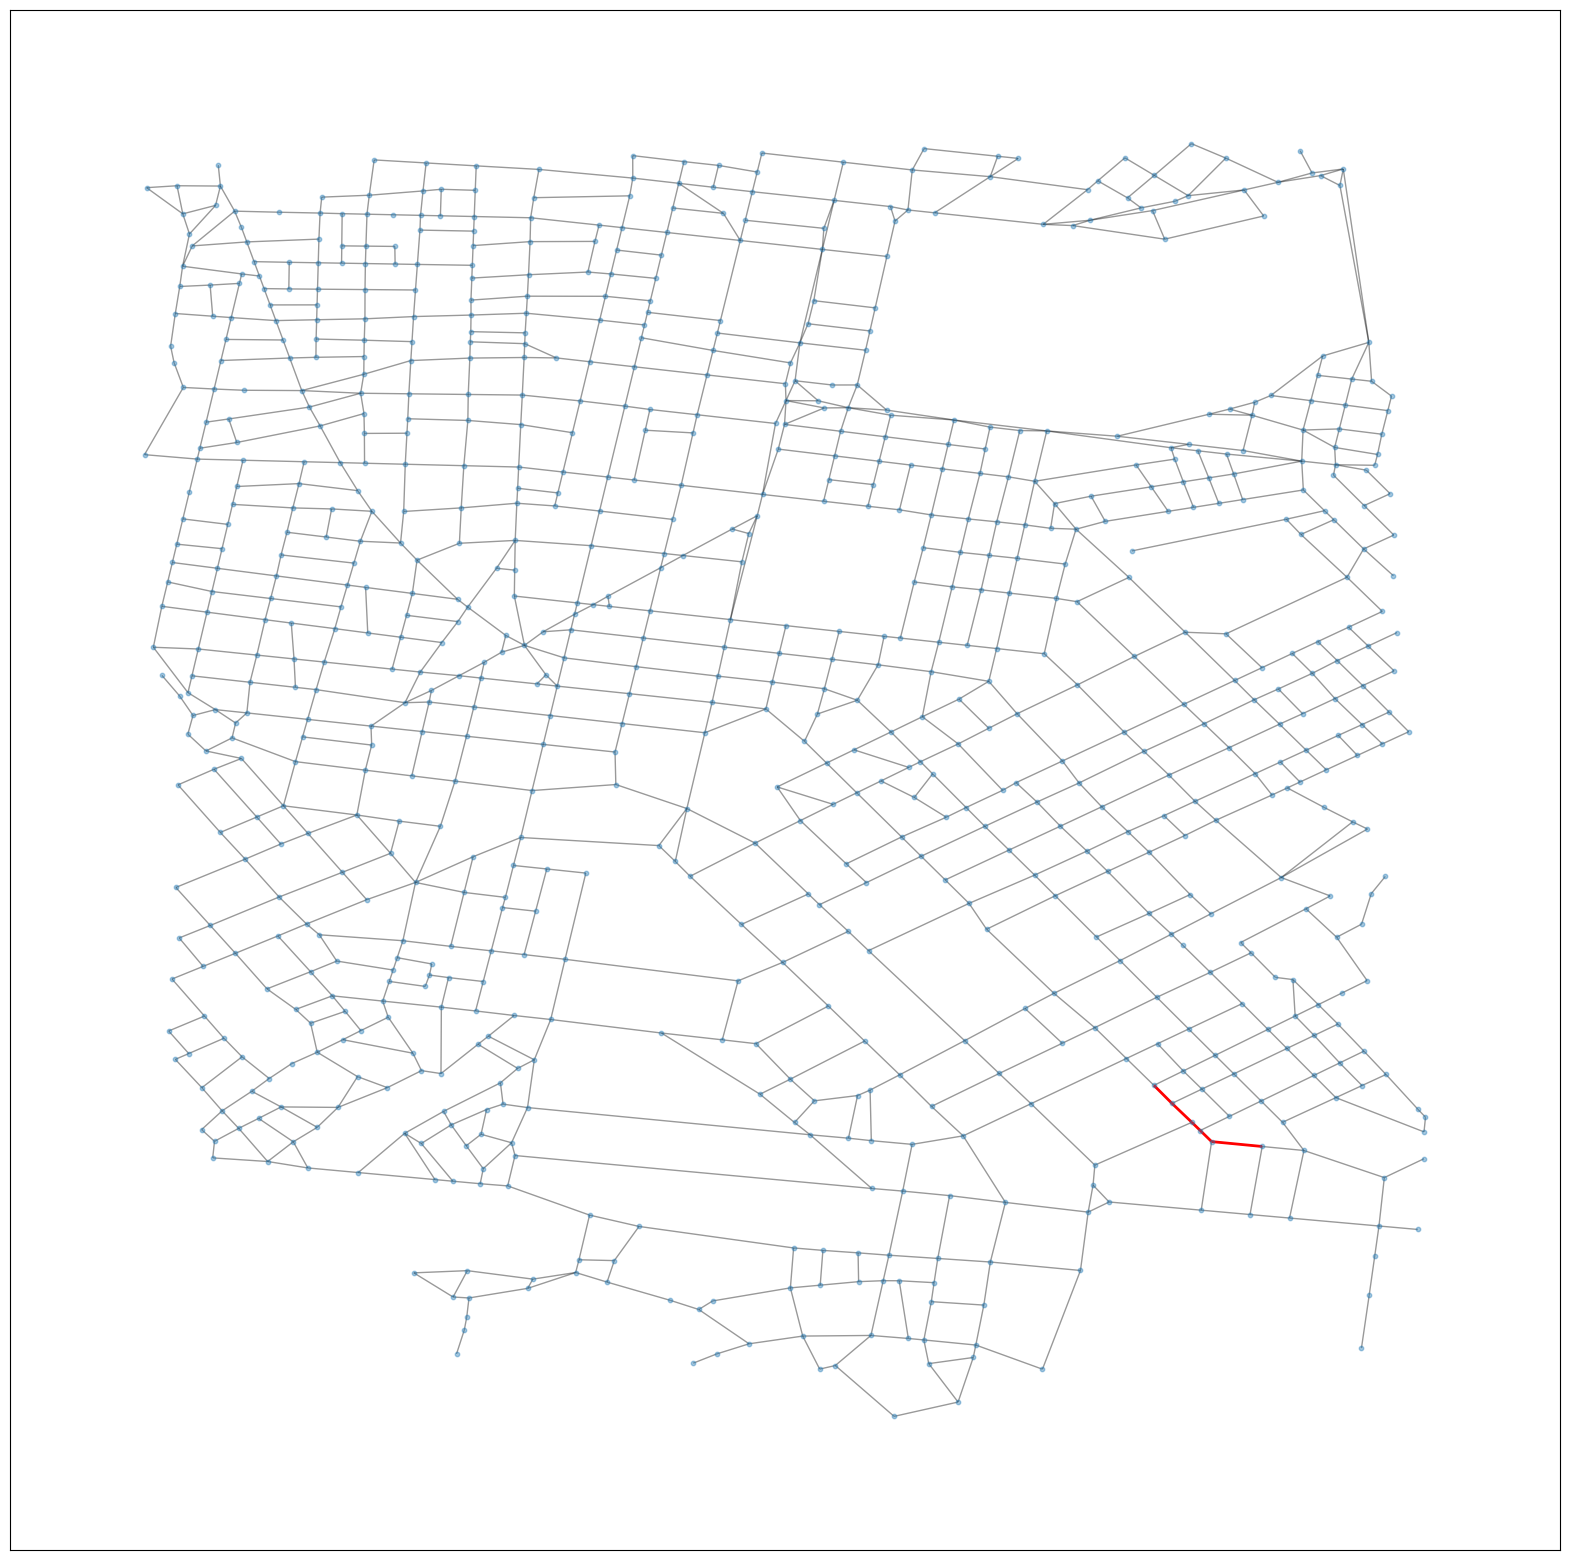

In [5]:
# visulize the trajectories from the list "trajectories" created by the dataloader
fig, ax = plt.subplots(figsize=(20, 20))
data.trajectories[0].plot(data.graph, ax)

In [6]:
# only use batch_size=1 for now
# each batch contains full trajectory, masking has to happen later
dataloader = torch.utils.data.DataLoader(data, batch_size=1)

<style>
.custom-font {
    font-family: 'Times New Roman', Times, serif;
    font-size: 48px;
    background-color: lightblue;
    color: black
}
</style>

<p class="custom-font">
Simple GNN



</p>


In [7]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn.dense import DenseGCNConv
import torch.nn.functional as F
from tqdm import tqdm

In [8]:
class SimpleGNN(torch.nn.Module):
	def __init__(self, node_features):
		super().__init__()
		self.conv1 = GCNConv(node_features+1, node_features)
		self.linear = torch.nn.Linear(node_features, 16)
		self.linear2 = torch.nn.Linear(16, 1)

	def forward(self, x, edge_index):

		x = self.conv1(x, edge_index)
		x = F.relu(x)
		next_node = self.linear(x)
		next_node = F.relu(next_node)
		next_node = self.linear2(next_node)

		return x, next_node

In [9]:
feature_dim = 16

model = SimpleGNN(data.graph.node_coordinates.shape[1] + feature_dim)

In [10]:
min_history = 3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_f = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

In [11]:
# local_loss == True: Apply loss function only to neighbors of last node
# local_loss == False: Apply loss function to all nodes of graph
local_loss = True

model.train()
epochs = tqdm(range(50), desc='')
for epoch in epochs:
    epoch_accuracy = []
    epoch_loss = []
    for batch in dataloader:
        batch = batch.squeeze(0)
        mask = torch.arange(batch.shape[0]-min_history)[:, None]+min_history > torch.arange(batch.shape[0])
        for y_pos, m in enumerate(mask):
            x = batch[m]
            y = batch[min_history+y_pos]

            nfeatures = torch.tensor(data.graph.node_coordinates)
            nfeatures = torch.concat([nfeatures, torch.zeros(nfeatures.shape[0], feature_dim)], dim=1)
            for edge in x:
                on_path = torch.zeros(nfeatures.shape[0], 1)
                on_path[edge] = 1
                nfeatures = torch.concat([nfeatures, on_path], dim=1).to(dtype=torch.float32)
                nfeatures, next_node = model(nfeatures, data.graph.edge_index)
            
            last_node = x[-1][1].item()
            y_node = y[1].item()
            
            last_node_neighbors = list(data.graph.get_neighbors(last_node))
            neighbor_scores = next_node[last_node_neighbors]

            if local_loss:
                loss = loss_f(neighbor_scores.squeeze(1), torch.eye(len(last_node_neighbors))[last_node_neighbors.index(y_node)])
            else:
                loss = loss_f(next_node.squeeze(1), torch.tensor(y_node))
            epoch_accuracy.append(torch.mean((neighbor_scores.argmax(dim=0) == last_node_neighbors.index(y_node))*1.0))

            loss.backward()
            epoch_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()

    accuracies.append(np.array(epoch_accuracy).mean())
    losses.append(np.array(epoch_loss).mean())
    epochs.set_description(f"{losses[-1]:.4f} {accuracies[-1]:.3f}")
        

0.4665 0.655: 100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


Text(0.5, 1.0, 'accuracy')

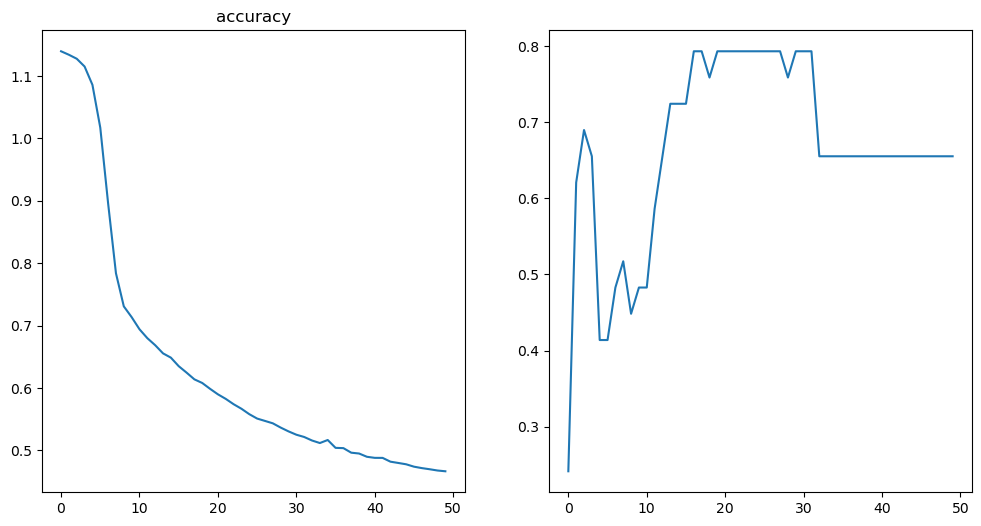

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(np.arange(len(losses)), np.array(losses))
axs[0].set_title("loss")
axs[1].plot(np.arange(len(accuracies)), np.array(accuracies))
axs[0].set_title("accuracy")